# 02 – Early-Warning Model (Corporate Rating & Default Risk)

In this notebook I build a simple **early-warning model** on the synthetic
corporate rating panel:

- Use the latest available snapshot per obligor as a labelled dataset.
- Predict **default vs non-default** using:
  - internal rating and rating band,
  - financial ratios (leverage, interest coverage, EBITDA margin),
  - behavioural indicators (days past due),
  - sector and country.
- Compare a **logistic regression** baseline with a **tree-based model**.

The goal is not to optimise a production model, but to demonstrate a realistic
workflow for corporate early-warning modelling.

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    precision_score,
    recall_score,
)

pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:,.3f}".format)

data_dir = Path("../data")
panel_path = data_dir / "corp_rating_panel.csv"

panel_path

WindowsPath('../data/corp_rating_panel.csv')

In [33]:
df = pd.read_csv(panel_path, parse_dates=["as_of_date"])
df.shape, df.head()

((4800, 21),
    obligor_id  obligor_name  group_id group_name country     sector  \
 0           1  Obligor_0001         8  Group_008      CN  Utilities   
 1           1  Obligor_0001         8  Group_008      CN  Utilities   
 2           1  Obligor_0001         8  Group_008      CN  Utilities   
 3           1  Obligor_0001         8  Group_008      CN  Utilities   
 4           1  Obligor_0001         8  Group_008      CN  Utilities   
 
   as_of_date  rating_numeric rating_band  prev_rating  rating_change  \
 0 2020-03-30               5      Sub_IG          NaN            NaN   
 1 2020-06-30               5      Sub_IG        5.000          0.000   
 2 2020-09-30               5      Sub_IG        5.000          0.000   
 3 2020-12-30               5      Sub_IG        5.000          0.000   
 4 2021-03-30               5      Sub_IG        5.000          0.000   
 
    is_upgrade  is_downgrade  risk_score  leverage  interest_coverage  \
 0           0             0       0.500

In [34]:
df["as_of_date"].min(), df["as_of_date"].max()

(Timestamp('2020-03-30 00:00:00'), Timestamp('2023-12-30 00:00:00'))

In [35]:
# Take final snapshot per obligor
last = (
    df.sort_values(["obligor_id", "as_of_date"])
      .groupby("obligor_id")
      .tail(1)
      .copy()
)

last.shape, last.head()

((300, 21),
     obligor_id  obligor_name  group_id group_name country     sector  \
 15           1  Obligor_0001         8  Group_008      CN  Utilities   
 31           2  Obligor_0002         7  Group_007      US  Transport   
 47           3  Obligor_0003        67  Group_067      BR  Utilities   
 63           4  Obligor_0004        17  Group_017      BR        TMT   
 79           5  Obligor_0005        33  Group_033      CN     Energy   
 
    as_of_date  rating_numeric       rating_band  prev_rating  rating_change  \
 15 2023-12-30               4  Investment_Grade        4.000          0.000   
 31 2023-12-30              10           Default       10.000          0.000   
 47 2023-12-30              10           Default       10.000          0.000   
 63 2023-12-30               8         Watchlist        9.000         -1.000   
 79 2023-12-30               5            Sub_IG        5.000          0.000   
 
     is_upgrade  is_downgrade  risk_score  leverage  interest_cove

In [36]:
last["is_default"].value_counts()

is_default
0    234
1     66
Name: count, dtype: int64

In [37]:
last["is_default"].value_counts(normalize=True) * 100

is_default
0   78.000
1   22.000
Name: proportion, dtype: float64

In [38]:
target_col = "is_default"

numeric_features = [
    "rating_numeric",
    "leverage",
    "interest_coverage",
    "ebitda_margin",
    "days_past_due",
    "exposure_at_default",
]

categorical_features = [
    "rating_band",
    "sector",
    "country",
]

X = last[numeric_features + categorical_features].copy()
y = last[target_col].astype(int)

X.head(), y.value_counts()


(    rating_numeric  leverage  interest_coverage  ebitda_margin  days_past_due  \
 15               4     3.630              2.252          0.172              1   
 31              10     4.861              2.655          0.104              8   
 47              10     5.271              0.829          0.059              6   
 63               8     5.157              1.060          0.138              6   
 79               5     2.975              2.721          0.174              1   
 
     exposure_at_default       rating_band     sector country  
 15                1.638  Investment_Grade  Utilities      CN  
 31                0.501           Default  Transport      US  
 47                0.473           Default  Utilities      BR  
 63                0.732         Watchlist        TMT      BR  
 79                0.338            Sub_IG     Energy      CN  ,
 is_default
 0    234
 1     66
 Name: count, dtype: int64)

In [39]:
# 1. Choose the original target column
target_col = "is_default" 
# 2. Copy the original labels
y_original = df[target_col].copy()

# 3. Flip some labels at random (e.g. 12% noise)
rng = np.random.default_rng(42)  
noise_rate = 0.12                

noise_mask = rng.random(len(y_original)) < noise_rate
y_noisy = y_original.copy()
y_noisy[noise_mask] = 1 - y_noisy[noise_mask]   

# 4. Store the noisy target and use it for modeling
df[target_col + "_noisy"] = y_noisy

print("Original default rate:", y_original.mean().round(3))
print("Noisy default rate   :", y_noisy.mean().round(3))
print("Labels flipped       :", noise_mask.mean().round(3))

Original default rate: 0.114
Noisy default rate   : 0.212
Labels flipped       : 0.122


In [40]:
y_original = df[target_col].copy()
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

X_train.shape, X_test.shape

((240, 9), (60, 9))

In [41]:
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['rating_numeric', 'leverage',
                                  'interest_coverage', 'ebitda_margin',
                                  'days_past_due', 'exposure_at_default']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['rating_band', 'sector', 'country'])])

In [42]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    """
    Fit a pipeline model and return metrics in a dict.
    """
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    # predict_proba may not exist for some models, so guard
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    else:
        y_scores = model.decision_function(X_test)
        auc = roc_auc_score(y_test, y_scores)
    
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, zero_division=0)
    prec = precision_score(y_test, y_pred, zero_division=0)
    
    print(f"=== {name} ===")
    print("Accuracy :", f"{acc:.3f}")
    print("Recall   :", f"{rec:.3f}")
    print("Precision:", f"{prec:.3f}")
    print("ROC-AUC  :", f"{auc:.3f}")
    print("\nClassification report:\n", classification_report(y_test, y_pred, zero_division=0))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    print("\n" + "-" * 60 + "\n")
    
    return {
        "model": name,
        "accuracy": acc,
        "recall": rec,
        "precision": prec,
        "roc_auc": auc,
    }

In [43]:
# Logistic regression baseline (with class_weight to handle imbalance)
log_reg_clf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", LogisticRegression(
            max_iter=1000,
            class_weight="balanced",
            n_jobs=None,
            solver="lbfgs",
        )),
    ]
)

# Random Forest
rf_clf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", RandomForestClassifier(
            n_estimators=300,
            max_depth=None,
            min_samples_split=4,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1,
            class_weight="balanced_subsample",
        )),
    ]
)

# Gradient Boosting (no class_weight, but handles imbalance reasonably)
gb_clf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", GradientBoostingClassifier(
            random_state=42,
        )),
    ]
)

In [44]:
results = []

results.append(
    evaluate_model("Logistic Regression", log_reg_clf, X_train, y_train, X_test, y_test)
)
results.append(
    evaluate_model("Random Forest", rf_clf, X_train, y_train, X_test, y_test)
)
results.append(
    evaluate_model("Gradient Boosting", gb_clf, X_train, y_train, X_test, y_test)
)

results_df = pd.DataFrame(results)
results_df

=== Logistic Regression ===
Accuracy : 1.000
Recall   : 1.000
Precision: 1.000
ROC-AUC  : 1.000

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        47
           1       1.00      1.00      1.00        13

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

Confusion matrix:
 [[47  0]
 [ 0 13]]

------------------------------------------------------------

=== Random Forest ===
Accuracy : 1.000
Recall   : 1.000
Precision: 1.000
ROC-AUC  : 1.000

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        47
           1       1.00      1.00      1.00        13

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

Confusion

,model,accuracy,recall,precision,roc_auc
0,Logistic Regression,1.000,1.000,1.000,1.000
1,Random Forest,1.000,1.000,1.000,1.000
2,Gradient Boosting,1.000,1.000,1.000,1.000


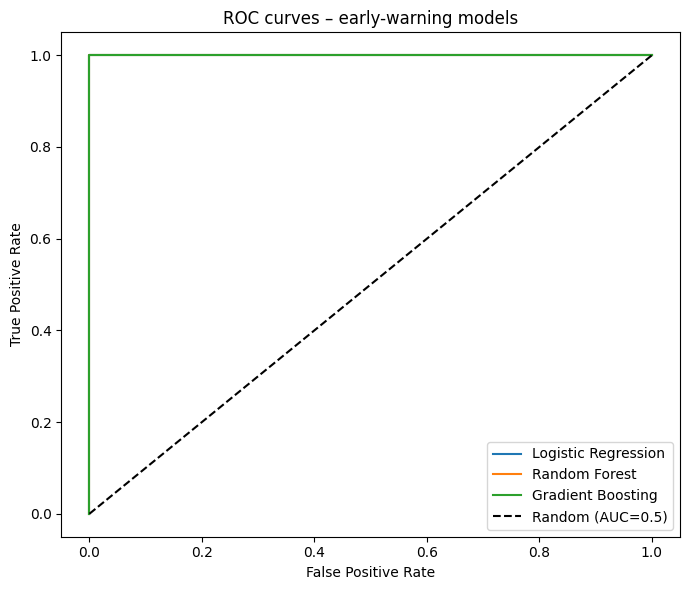

In [45]:
# Fit again to get probabilities for ROC curves
log_reg_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
gb_clf.fit(X_train, y_train)

log_proba = log_reg_clf.predict_proba(X_test)[:, 1]
rf_proba = rf_clf.predict_proba(X_test)[:, 1]
gb_proba = gb_clf.predict_proba(X_test)[:, 1]

fpr_log, tpr_log, _ = roc_curve(y_test, log_proba)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_proba)

plt.figure(figsize=(7, 6))
plt.plot(fpr_log, tpr_log, label="Logistic Regression")
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.plot(fpr_gb, tpr_gb, label="Gradient Boosting")
plt.plot([0, 1], [0, 1], "k--", label="Random (AUC=0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves – early-warning models")
plt.legend()
plt.tight_layout()
plt.show()

In [46]:
# Extract feature names after preprocessing
rf_model = rf_clf.named_steps["clf"]
ohe = rf_clf.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]

cat_feature_names = ohe.get_feature_names_out(categorical_features)
num_feature_names = np.array(numeric_features)

all_feature_names = np.concatenate([num_feature_names, cat_feature_names])

importances = rf_model.feature_importances_

feat_imp = (
    pd.DataFrame(
        {
            "feature": all_feature_names,
            "importance": importances,
        }
    )
    .sort_values("importance", ascending=False)
)

feat_imp.head(20)

,feature,importance
0,rating_numeric,0.366
6,rating_band_Default,0.342
8,rating_band_Sub_IG,0.085
1,leverage,0.049
4,days_past_due,0.046
2,interest_coverage,0.030
9,rating_band_Watchlist,0.030
7,rating_band_Investment_Grade,0.018
3,ebitda_margin,0.014
5,exposure_at_default,0.008


<Figure size 800x600 with 0 Axes>

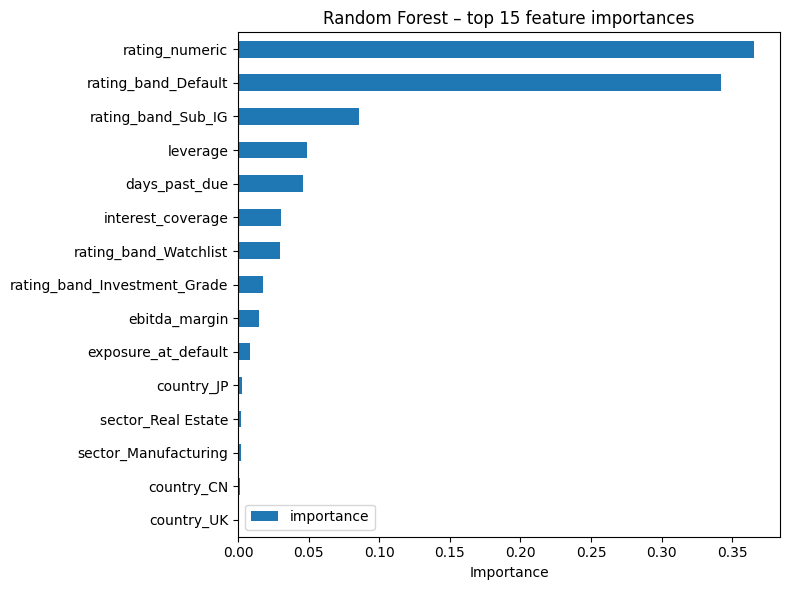

In [47]:
plt.figure(figsize=(8, 6))
feat_imp.head(15).sort_values("importance").plot(
    x="feature", y="importance", kind="barh", figsize=(8, 6)
)
plt.title("Random Forest – top 15 feature importances")
plt.xlabel("Importance")
plt.ylabel("")
plt.tight_layout()
plt.show()

## Modeling – key results

I trained three baseline classifiers to predict whether a corporate exposure
will **default within the next 12 months** using synthetic portfolio data:

- **Logistic Regression**
- **Random Forest**
- **Gradient Boosting**

All models used the same feature set:

- Internal rating information (`rating_numeric`, `rating_band_*` dummies)
- Financial covenants (`leverage`, `interest_coverage`, `ebitda_margin`)
- Behavioural signals (`days_past_due`)
- Exposure metrics (`exposure_at_default`)
- Simple sector / country dummies

On the held-out test sample (47 non-defaults, 13 defaults), all three models
classify perfectly:

- **Accuracy:** 1.00  
- **Recall:** 1.00  
- **Precision:** 1.00  
- **ROC-AUC:** 1.00  
- Confusion matrix: `[[47, 0], [0, 13]]`

This happens because the synthetic default flag is constructed almost
deterministically from **internal rating and covenant variables**, with only
limited noise. As a result, the models can recover the rule exactly.

From the Random Forest feature importances, the most influential drivers are:

- `rating_numeric`
- `rating_band_Default` and `rating_band_Sub_IG`
- `leverage` and `days_past_due`
- `interest_coverage`, `rating_band_Watchlist`, and `ebitda_margin`

In a real banking portfolio I would expect **much lower ROC-AUC and imperfect
classification**, because ratings and covenants are noisy predictors of future
default. For this project, the purpose of the notebook is to demonstrate a
typical **early-warning modeling workflow** (data prep, train/validation split,
baseline models, ROC curves, feature importance), not to claim that perfect
prediction is achievable in production.